In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MarketingConsultant').getOrCreate()

In [2]:
df = spark.read.csv('bank.csv',inferSchema=True,
                     header=True,)

df.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,EmpVarRate,ConsPriceIDX,ConsConfIDX,euribor3m,NrEmployed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0


In [3]:
#splitting our dataset into test and train set in a ratio of 70% train and 30% test 
train, test = df.randomSplit([0.7, 0.3], seed=10)


In [4]:
#Renaming the train and test set label 
def renamelabel(df):
    df = df.withColumnRenamed("y","label")
    return df 

train = renamelabel(train)
test = renamelabel(test)
    


In [5]:
#checking the label using pandas dataframe 
train.toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,EmpVarRate,ConsPriceIDX,ConsConfIDX,euribor3m,NrEmployed,label
0,18,student,single,basic.4y,no,no,no,cellular,apr,thu,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099,0
1,18,student,single,high.school,no,no,no,telephone,nov,thu,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.245,5196,0
2,19,student,single,basic.4y,no,no,yes,cellular,apr,wed,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099,1
3,19,student,single,basic.6y,no,no,no,cellular,mar,tue,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.556,5099,1
4,19,student,single,basic.9y,no,yes,no,cellular,mar,fri,...,4,999,0,nonexistent,-1.8,92.843,-50.0,1.640,5099,1


In [6]:
#applying Yeo-Johnson
#Spark dataframe is incompatible with this transformation so It needed to be transformed into pandas df 
from feature_engine import transformation as vt
tf = vt.YeoJohnsonTransformer(variables = ['age','duration'])
tf.fit(train.toPandas())
train= tf.transform(train.toPandas())
test= tf.transform(test.toPandas())



In [7]:
#changing it back to the spark dataframe 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
train = spark.createDataFrame(train)
test = spark.createDataFrame(test)

In [8]:
#separating into categorical and numerical
catCols = [x for (x, dataType) in train.dtypes if dataType == "string" ]

numCols = [x for (x, dataType) in train.dtypes if ((dataType != "string") & (x != "label"))]

In [9]:
catCols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [10]:
#applying String indexer and then One hot encoder 
from pyspark.ml.feature import StringIndexer, OneHotEncoder
string_indexer = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in catCols]
one_hot_encoder = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in catCols]

In [11]:
#Creating the input of the Vecotrassembler
from pyspark.ml.feature import VectorAssembler
assembler = [x for x in numCols]
assembler += [f"{x}_one_hot" for x in catCols]

In [12]:
#Creating the verctor by using vectorassembler 
vector_assembler = VectorAssembler(
    inputCols= assembler, outputCol= "vfeatures"
)

In [13]:
#Scaling our dataset using MinMax Scaler
from pyspark.ml.feature import MinMaxScaler
std_scaler = MinMaxScaler(inputCol="vfeatures", outputCol="features")

Creating feature engineering steps.

In [14]:
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages += [std_scaler]

Adding the data transformation to the train and test separately using pipelines.

In [15]:
from pyspark.ml import Pipeline
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(train)
train = model.transform(train)
test = model.transform(test)

In [16]:
train.select('label',"features").show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(53,[0,1,3,5,6,7,...|
|    0|(53,[0,1,3,5,6,7,...|
+-----+--------------------+
only showing top 2 rows



Defining the layers for the Artificial Neural Network

In [17]:
x=train.schema["features"].metadata["ml_attr"]["num_attrs"]
layers = [x, 10, 5, 2]

Models to be evaluated

In [18]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC , MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
lr = LogisticRegression(featuresCol= 'features', labelCol='label')
dt=DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
rf = RandomForestClassifier(featuresCol='features', labelCol="label")
gbt = GBTClassifier(featuresCol="features", labelCol="label",  maxIter=10)
lsvc = LinearSVC(labelCol="label",maxIter=10, regParam=0.1)
ANeN = MultilayerPerceptronClassifier(labelCol='label',
                                            featuresCol='features',
                                            predictionCol='prediction',
                                            layers=layers,
                                            seed=1234,
                                            maxIter=100)

Logistic Regression Model


In [19]:
# Fit the model
lrmodel = lr.fit(train)
# Test the model performance on the test dataset
predictions = lrmodel.transform(test)

In [20]:
import sklearn
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11010
           1       0.67      0.42      0.51      1405

    accuracy                           0.91     12415
   macro avg       0.80      0.69      0.73     12415
weighted avg       0.90      0.91      0.90     12415

[[10719   291]
 [  821   584]]


In [21]:
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_AUC  = lr_eval.evaluate(predictions)
print("AUC = " , lr_AUC)


AUC =  0.9400896952301532


Decision Tree Model

In [22]:
# Fit the model
dt_model = dt.fit(train)
# Test the model performance on the test dataset
dt_predictions= dt_model.transform(test)

In [23]:
dty_true = dt_predictions.select(['label']).collect()
dty_pred = dt_predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(dty_true, dty_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11010
           1       0.65      0.53      0.58      1405

    accuracy                           0.91     12415
   macro avg       0.80      0.75      0.77     12415
weighted avg       0.91      0.91      0.91     12415



In [24]:
dt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
dt_AUC  = dt_eval.evaluate(dt_predictions)
print("Decision Tree Performance Measure")
print("AUC =" , dt_AUC)

Decision Tree Performance Measure
AUC = 0.9171334050895175


Random Forest Model

In [25]:
# Fit the model
rf_model = rf.fit(train)
# Test the model performance on the test dataset
rf_prediction = rf_model.transform(test)

In [26]:
rf_true = rf_prediction.select(['label']).collect()
rf_pred = rf_prediction.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(rf_true, rf_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     11010
           1       0.79      0.16      0.26      1405

    accuracy                           0.90     12415
   macro avg       0.85      0.58      0.61     12415
weighted avg       0.89      0.90      0.87     12415



In [27]:
rf_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_AUC  = rf_eval.evaluate(rf_prediction)
print("Random Forest Performance Measure")
print("AUC = " , rf_AUC)

Random Forest Performance Measure
AUC =  0.9190905388501555


Gradient Boost Tree

In [28]:
# Fit the model
gbt_model = gbt.fit(train)
# Test the model performance on the test dataset
gbt_predictions = gbt_model.transform(test)

In [29]:
gbr_true = gbt_predictions.select(['label']).collect()
gbr_pred = gbt_predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(gbr_true, gbr_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     11010
           1       0.66      0.49      0.56      1405

    accuracy                           0.91     12415
   macro avg       0.80      0.73      0.76     12415
weighted avg       0.91      0.91      0.91     12415



In [30]:
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
gbt_AUC  = gbt_eval.evaluate(gbt_predictions)
print("Gradient Boost Performance Measure")
print("AUC = " , gbt_AUC)

Gradient Boost Performance Measure
AUC =  0.9383124044462974


SVC

In [31]:
# Fit the model
svcModel = lsvc.fit(train)
# Test the model performance on the test dataset
svcpred = svcModel.transform(test)

In [32]:
svc_true = svcpred.select(['label']).collect()
svc_pred = svcpred.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(svc_true, svc_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11010
           1       0.69      0.20      0.31      1405

    accuracy                           0.90     12415
   macro avg       0.80      0.59      0.63     12415
weighted avg       0.88      0.90      0.87     12415



In [33]:
svc_eval = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
svc_AUC  = svc_eval.evaluate(svcpred)
print("SVC Performance Measure")
print("AUC =" , svc_AUC)

SVC Performance Measure
AUC = 0.9303120747557218


ANN

In [34]:
# Fit the model
ANNmodel = ANeN.fit(train)
# Test the model performance on the test dataset
ANNpred = ANNmodel.transform(test)

In [35]:
import sklearn
ANNy_true = ANNpred.select(['label']).collect()
ANNy_pred = ANNpred.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ANNy_true, ANNy_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11010
           1       0.64      0.52      0.57      1405

    accuracy                           0.91     12415
   macro avg       0.79      0.74      0.76     12415
weighted avg       0.91      0.91      0.91     12415



In [36]:
cmatrix = confusion_matrix(ANNy_true, ANNy_pred)
cmatrix

array([[10600,   410],
       [  679,   726]], dtype=int64)

In [37]:

ANN_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
ANN_AUC  = ANN_eval.evaluate(ANNpred)
print("AUC = " , ANN_AUC)

AUC =  0.9438620665134574


Logistic Regression feature importance

In [40]:
import pandas as pd 
LRDF = (pd.DataFrame(list(zip(vector_assembler.getInputCols(),
                            lrmodel.coefficients)),
                            columns= ['feature', 'importance'])
                            .sort_values(by='importance', ascending=False))
LRDF
                            

,feature,importance
1,duration,15.993798
6,ConsPriceIDX,4.776473
8,euribor3m,2.788140
15,loan_one_hot,0.703030
19,poutcome_one_hot,0.367445
18,day_of_week_one_hot,0.345337
7,ConsConfIDX,0.249193
14,housing_one_hot,0.243107
10,job_one_hot,0.223561
12,education_one_hot,0.176330


In [41]:
data = pd.read_csv('bank-additional-full.csv')

Text(0.5, 1.0, 'Distribution of duration regarding the campaign success')

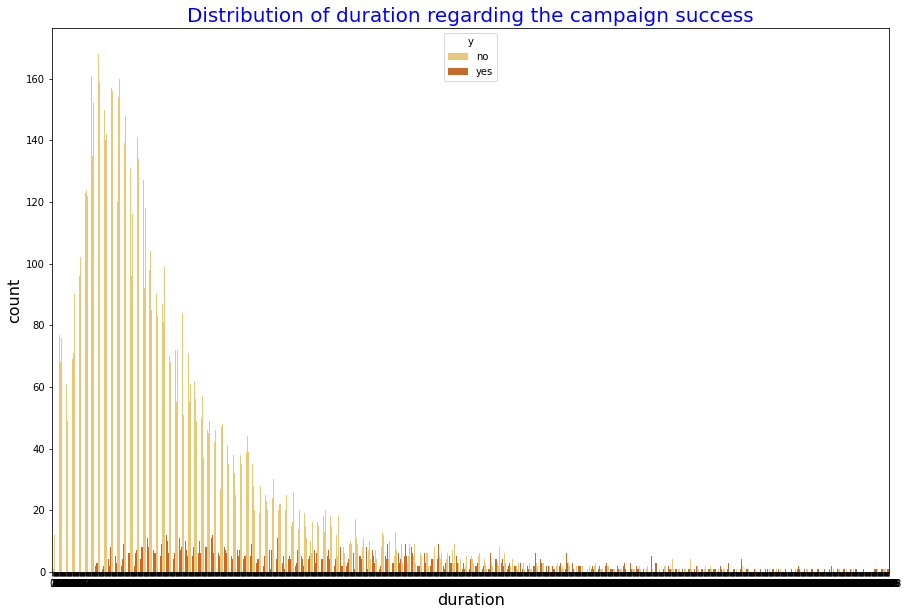

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 10))
plt.xlabel("Duration", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
drt = sns.countplot(x = data["duration"], hue = data["y"], palette="YlOrBr")
drt.set_title("Distribution of duration regarding the campaign success", color = "blue", fontsize = 20)

Text(0.5, 1.0, 'Duration')

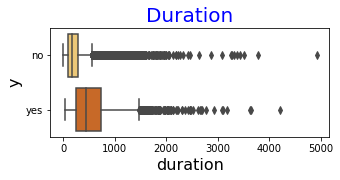

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (5, 2))
plt.xlabel("Duration", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
drt = sns.boxplot(x= data["duration"], y= data["y"], palette="YlOrBr")
drt.set_title("Duration", color = "blue", fontsize = 20)

In [44]:
from numpy import min, max, std, round, median
data[['duration', 'y']].groupby('y').agg(['mean','median','std','min', 'max'])

duration                             
           mean median         std min   max
y                                           
no   220.844807  163.5  207.096293   0  4918
yes  553.191164  449.0  401.171871  37  4199